In [1]:
!unzip drive/MyDrive/archive.zip # unzip the dataset

Archive:  drive/MyDrive/archive.zip
replace seg_pred/seg_pred/10004.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: seg_pred/seg_pred/10004.jpg  
replace seg_pred/seg_pred/10005.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: seg_pred/seg_pred/10005.jpg  
replace seg_pred/seg_pred/10012.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
import tensorflow as tf  # defining and training neural networks.
from timeit import default_timer as timer # measure the time taken for certain operations
import numpy as np # numerical operations

import pandas as pd # data manipulation and analysis library

from tensorflow import keras # Keras neural networks API, simplifying model construction.

from keras.applications import ResNet50
from keras.preprocessing import image
#  pre-trained models like ResNet50 and image-related operations.

from keras.preprocessing.image import ImageDataGenerator
#  data augmentation, artificially increasing the size of the training dataset.

from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
#building models and implementing training callbacks.

from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization, LSTM, ConvLSTM2D
# constructing the architecture of the neural network.

from keras.losses import categorical_crossentropy
# Categorical crossentropy is a common loss function for multi-class classification problems.


In [3]:
# paths of data
train_path = 'seg_train/seg_train'
test_path = 'seg_test/seg_test'
pred_path = 'seg_pred/seg_pred'

In [4]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,                # Rescale pixel values to [0, 1]
    rotation_range=20,              # Random rotation within 20 degrees
    width_shift_range=0.2,          # Random horizontal shift by 20% of image width
    height_shift_range=0.2,         # Random vertical shift by 20% of image height
    horizontal_flip=True,           # Random horizontal flipping
    fill_mode='nearest'             # Fill mode for new pixels after shifts/rotations
)

In [5]:
size_images = 150
batch_size = 64

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_path,                     # Path to the training data
    target_size=(size_images, size_images),  # Resize images to this size
    batch_size=batch_size,           # Number of images in each batch
    seed=32,                         # Optional: Set a random seed for shuffling
    shuffle=True,                    # Shuffle the data during training
    class_mode='categorical'        # Mode for class labels (categorical for one-hot encoding)
)

Found 14034 images belonging to 6 classes.


In [7]:
test_datagen = ImageDataGenerator(rescale=1./255)


validation_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(size_images,size_images),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

Found 3000 images belonging to 6 classes.


In [8]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label in in train and validation datasets\n")

for key, value in labels.items():
    print(f'{key} : {value}')

Label in in train and validation datasets

0 : buildings
1 : forest
2 : glacier
3 : mountain
4 : sea
5 : street


In [9]:

from keras.models import Sequential
model = Sequential()

In [10]:
#convolution matrix 1
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 3)))# kernel of 3*3
model.add(BatchNormalization())# improve the training stability and convergence speed
model.add(MaxPooling2D(pool_size=(2,2)))#pooling layer
model.add(Dropout(0.2))
#convolution matrix 2
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
#convolution matrix 3
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))# prevention from overfitting
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))# softmax:classify inputs into more than two classes.

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 75, 75, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 75, 75, 64)        2

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience = 5, min_lr =1e-6, verbose=1)

In [14]:
history = model.fit(train_generator, validation_data = validation_generator, batch_size = 64, epochs= 15, verbose = 1)


Epoch 1/15
220/220 [==============================] - 113s 475ms/step - loss: 1.0207 - accuracy: 0.6270 - val_loss: 4.9975 - val_accuracy: 0.2217
Epoch 2/15
220/220 [==============================] - 101s 460ms/step - loss: 0.7208 - accuracy: 0.7353 - val_loss: 3.6871 - val_accuracy: 0.3547
Epoch 3/15
220/220 [==============================] - 97s 440ms/step - loss: 0.6227 - accuracy: 0.7709 - val_loss: 1.9727 - val_accuracy: 0.5293
Epoch 4/15
220/220 [==============================] - 97s 442ms/step - loss: 0.5672 - accuracy: 0.7944 - val_loss: 2.3432 - val_accuracy: 0.5397
Epoch 5/15
220/220 [==============================] - 99s 452ms/step - loss: 0.5500 - accuracy: 0.8006 - val_loss: 1.0783 - val_accuracy: 0.7043
Epoch 6/15
220/220 [==============================] - 99s 451ms/step - loss: 0.5020 - accuracy: 0.8139 - val_loss: 1.1577 - val_accuracy: 0.6843
Epoch 7/15
220/220 [==============================] - 101s 458ms/step - loss: 0.4862 - accuracy: 0.8250 - val_loss: 0.8022 - val

In [47]:
model.evaluate(validation_generator)


47/47 [==============================] - 3s 66ms/step - loss: 0.0366


0.03659640625119209

In [34]:
import os
from PIL import Image
pred_img_list = [f"seg_pred/seg_pred/{i}" for i in os.listdir("seg_pred/seg_pred")]

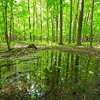

1
forest


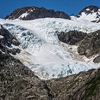

2
glacier


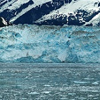

2
glacier


In [48]:
import random
from random import randint

for i in range(3):
  num = random.randint(0, len(pred_img_list))
  img = Image.open(pred_img_list[num])
  display(img.resize((100,100)))
  img = img.resize((150, 150))
  img_array = np.array(img)
  img_array = img_array[np.newaxis, :]
  prob = model(img_array)

  pred = np.argmax(prob)
  print(pred)
  print(labels[pred])



In [42]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [26]:
import matplotlib.pyplot as plt

# Assuming 'history' is a dictionary with keys 'accuracy', 'val_accuracy', 'loss', 'val_loss'
# Make sure it's defined and contains the expected data

# Plotting training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plotting training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


KeyError: ignored